In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Path to your file (adjust if needed)
FILE = r"C:\Users\SULTANUS SALEHIN\Desktop\BHI\Dataset\mental_health_dataset.xlsx"
df = pd.read_excel(FILE, sheet_name="Sheet1")

# Basic cleaning / feature engineering (safe to rerun)
df["completion_rate"] = np.where(
    df["mindfulness_therapies_started"] > 0,
    df["mindfulness_therapies_completed"] / df["mindfulness_therapies_started"],
    np.nan,
)
df["sex"] = df["sex"].astype("category")
df["condition_type"] = df["condition_type"].astype("category")
df["hospital_center_id"] = df["hospital_center_id"].astype("category")

# Quick peek
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   age                              209 non-null    float64 
 1   sex                              210 non-null    category
 2   hospital_center_id               210 non-null    category
 3   condition                        210 non-null    object  
 4   condition_type                   209 non-null    category
 5   bdi_ii_baseline                  209 non-null    float64 
 6   bdi_ii_after_intervention_12w    167 non-null    float64 
 7   bdi_ii_follow_up_24w             166 non-null    float64 
 8   mindfulness_therapies_started    210 non-null    int64   
 9   mindfulness_therapies_completed  210 non-null    int64   
 10  completion_rate                  171 non-null    float64 
dtypes: category(3), float64(5), int64(2), object(1)
memory usage: 14.5+ KB


,age,sex,hospital_center_id,condition,condition_type,bdi_ii_baseline,bdi_ii_after_intervention_12w,bdi_ii_follow_up_24w,mindfulness_therapies_started,mindfulness_therapies_completed,completion_rate
0,78.0,female,1,Cancer,Breast,10.0,3.0,7.0,14,13,0.928571
1,70.0,female,1,Cancer,Breast,4.0,4.0,8.0,14,12,0.857143
2,75.0,female,1,Cancer,Breast,18.0,10.0,13.0,4,4,1.000000
3,73.0,female,1,Cancer,Breast,11.0,NaN,NaN,0,0,NaN
4,62.0,female,1,Cancer,Breast,5.0,11.0,20.0,12,7,0.583333


## ANCOVA (Analysis of Covariance)

### ANCOVA at 12 weeks (Baseline)

In [2]:
# Complete-case for 12w
cc12 = df.dropna(subset=["bdi_ii_after_intervention_12w", "bdi_ii_baseline",
                         "age", "sex", "condition_type", "completion_rate"]).copy()

# ANCOVA (hospital as fixed effect optional: add + C(hospital_center_id))
formula12 = """
bdi_ii_after_intervention_12w ~ bdi_ii_baseline + age
+ C(sex) + C(condition_type) + completion_rate
"""

model12 = smf.ols(formula12, data=cc12)
fit12 = model12.fit(cov_type="cluster", cov_kwds={"groups": cc12["hospital_center_id"]})
print(fit12.summary())


                                  OLS Regression Results                                 
Dep. Variable:     bdi_ii_after_intervention_12w   R-squared:                       0.374
Model:                                       OLS   Adj. R-squared:                  0.329
Method:                            Least Squares   F-statistic:                     4.217
Date:                           Thu, 25 Sep 2025   Prob (F-statistic):              0.192
Time:                                   14:08:37   Log-Likelihood:                -467.49
No. Observations:                            150   AIC:                             957.0
Df Residuals:                                139   BIC:                             990.1
Df Model:                                     10                                         
Covariance Type:                         cluster                                         
                                                              coef    std err          z      P>|z| 

c:\Users\SULTANUS SALEHIN\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 10, but rank is 2
  warnings.warn('covariance of constraints does not have full '


### Coefficient Plot -ANCOVA (12w)

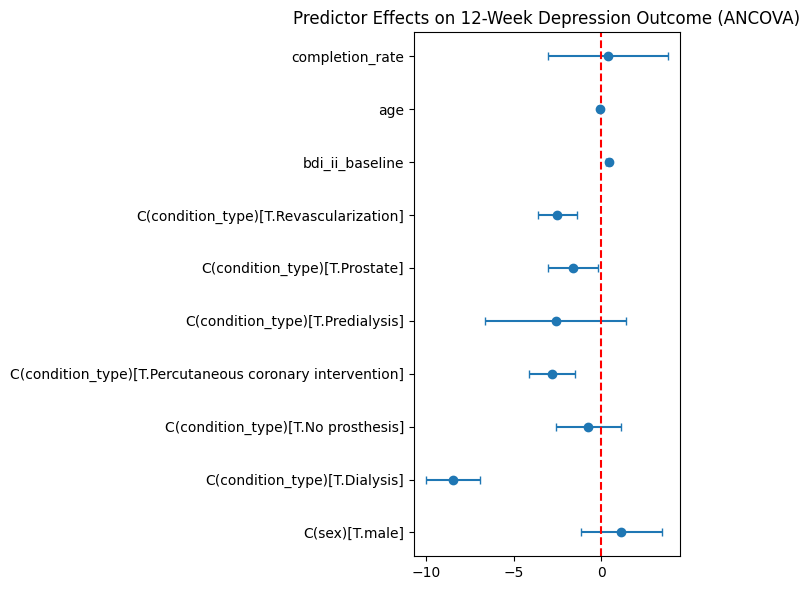

In [16]:
# Title: Predictor Effects on 12-Week Depression Outcome (ANCOVA)
# Caption: Estimated coefficients with 95% CIs from the 12-week ANCOVA model.
# Negative coefficients indicate factors associated with lower BDI-II at 12 weeks.

coef = fit12.params
ci   = fit12.conf_int()
plot12 = pd.DataFrame({"term": coef.index, "coef": coef.values,
                       "lo": ci[0].values, "hi": ci[1].values})
plot12 = plot12[plot12["term"] != "Intercept"]

plt.figure(figsize=(7,6))
y = np.arange(len(plot12))
plt.errorbar(plot12["coef"], y,
             xerr=[plot12["coef"]-plot12["lo"], plot12["hi"]-plot12["coef"]],
             fmt="o", capsize=3)
plt.yticks(y, plot12["term"])
plt.axvline(0, color="red", ls="--")
plt.title("Predictor Effects on 12-Week Depression Outcome (ANCOVA)")
plt.tight_layout(); plt.show()


### Adjusted means by condition type (ANCOVA)-12 Weeks

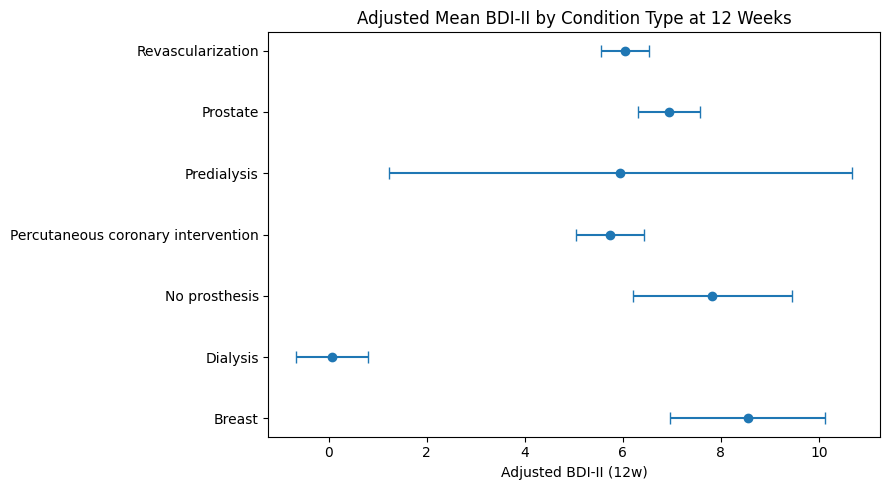

In [19]:
# Title: Adjusted Mean BDI-II by Condition Type at 12 Weeks
# Caption: Model-adjusted BDI-II by condition type, holding age, sex, baseline, and completion at reference values.
pred_grid12 = pd.DataFrame({
    "bdi_ii_baseline": ref_base,
    "age": ref_age,
    "completion_rate": ref_comp,
    "sex": ref_sex,
    "condition_type": cond_levels
})

pred12 = fit12.get_prediction(pred_grid12).summary_frame()
adj12  = pd.concat([pred_grid12["condition_type"].reset_index(drop=True), pred12], axis=1)

plt.figure(figsize=(9,5))
plt.errorbar(adj12["mean"], adj12["condition_type"],
             xerr=[adj12["mean"]-adj12["mean_ci_lower"], adj12["mean_ci_upper"]-adj12["mean"]],
             fmt="o", capsize=4)
plt.xlabel("Adjusted BDI-II (12w)")
plt.title("Adjusted Mean BDI-II by Condition Type at 12 Weeks")
plt.tight_layout(); plt.show()


In [3]:
# Build a small grid for adjusted predictions
ref_age = cc12["age"].median()
ref_base = cc12["bdi_ii_baseline"].median()
ref_comp = cc12["completion_rate"].median()
ref_sex = cc12["sex"].mode()[0]

pred_grid12 = pd.DataFrame({
    "bdi_ii_baseline": ref_base,
    "age": ref_age,
    "completion_rate": ref_comp,
    "sex": ref_sex,
    "condition_type": cc12["condition_type"].cat.categories
})

pred_res12 = fit12.get_prediction(pred_grid12).summary_frame()
adj12 = pd.concat([pred_grid12["condition_type"].reset_index(drop=True), pred_res12], axis=1)
adj12.rename(columns={"mean":"adj_BDI_12w","mean_ci_lower":"CI_low","mean_ci_upper":"CI_high"}, inplace=True)
adj12


,condition_type,adj_BDI_12w,mean_se,CI_low,CI_high,obs_ci_lower,obs_ci_upper
0,Breast,8.556871,0.796736,6.995298,10.118444,-2.671152,19.784894
1,Dialysis,0.092038,0.430133,-0.751008,0.935084,-11.058778,11.242855
2,No prosthesis,7.835200,0.877799,6.114745,9.555655,-3.416020,19.086420
3,Percutaneous coronary intervention,5.754547,0.394663,4.981022,6.528073,-5.391229,16.900323
4,Predialysis,5.965786,2.452899,1.158193,10.773379,-6.147964,18.079536
5,Prostate,6.954403,0.262605,6.439706,7.469099,-4.176406,18.085211
6,Revascularization,6.052445,0.266667,5.529787,6.575103,-5.078735,17.183624


In [4]:
cc24 = df.dropna(subset=["bdi_ii_follow_up_24w", "bdi_ii_baseline",
                         "age", "sex", "condition_type", "completion_rate"]).copy()

formula24 = """
bdi_ii_follow_up_24w ~ bdi_ii_baseline + age
+ C(sex) + C(condition_type) + completion_rate
"""

model24 = smf.ols(formula24, data=cc24)
fit24 = model24.fit(cov_type="cluster", cov_kwds={"groups": cc24["hospital_center_id"]})
print(fit24.summary())


                             OLS Regression Results                             
Dep. Variable:     bdi_ii_follow_up_24w   R-squared:                       0.275
Model:                              OLS   Adj. R-squared:                  0.223
Method:                   Least Squares   F-statistic:                     1.767
Date:                  Thu, 25 Sep 2025   Prob (F-statistic):              0.361
Time:                          14:09:05   Log-Likelihood:                -485.84
No. Observations:                   149   AIC:                             993.7
Df Residuals:                       138   BIC:                             1027.
Df Model:                            10                                         
Covariance Type:                cluster                                         
                                                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------

c:\Users\SULTANUS SALEHIN\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 10, but rank is 2
  warnings.warn('covariance of constraints does not have full '


### ANCOVA at 24 Weeks

In [6]:
# complete-case for 24w
cc24 = df.dropna(subset=[
    "bdi_ii_follow_up_24w", "bdi_ii_baseline",
    "age", "sex", "condition_type", "completion_rate"
]).copy()

# ANCOVA model (hospital fixed effect optional: add + C(hospital_center_id))
formula24 = """
bdi_ii_follow_up_24w ~ bdi_ii_baseline + age
+ C(sex) + C(condition_type) + completion_rate
"""

model24 = smf.ols(formula24, data=cc24)
fit24 = model24.fit(cov_type="cluster", cov_kwds={"groups": cc24["hospital_center_id"]})

print(fit24.summary())


                             OLS Regression Results                             
Dep. Variable:     bdi_ii_follow_up_24w   R-squared:                       0.275
Model:                              OLS   Adj. R-squared:                  0.223
Method:                   Least Squares   F-statistic:                     1.767
Date:                  Thu, 25 Sep 2025   Prob (F-statistic):              0.361
Time:                          14:14:06   Log-Likelihood:                -485.84
No. Observations:                   149   AIC:                             993.7
Df Residuals:                       138   BIC:                             1027.
Df Model:                            10                                         
Covariance Type:                cluster                                         
                                                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------

c:\Users\SULTANUS SALEHIN\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 10, but rank is 2
  warnings.warn('covariance of constraints does not have full '


### Coefficent Plot ANCOVA (24w)

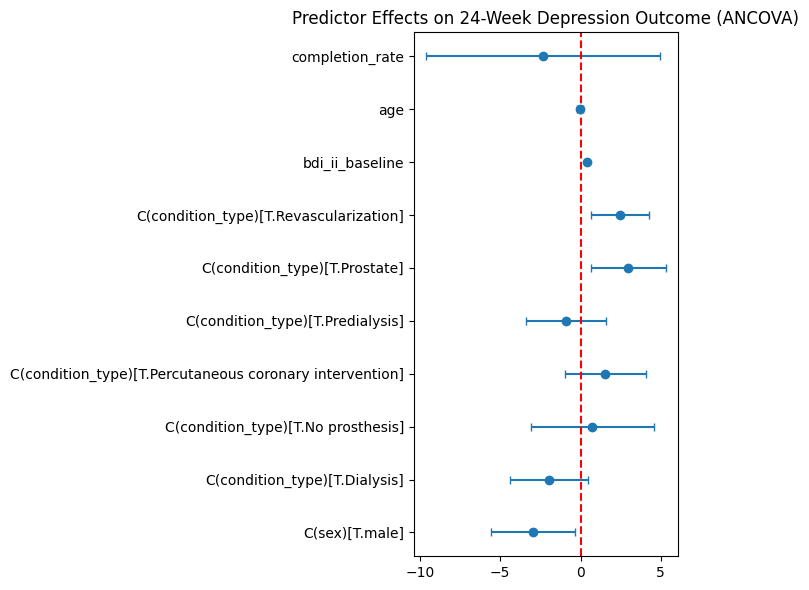

In [17]:
# Title: Predictor Effects on 24-Week Depression Outcome (ANCOVA)
# Caption: Estimated coefficients with 95% CIs from the 24-week ANCOVA model.

coef = fit24.params
ci   = fit24.conf_int()
plot24 = pd.DataFrame({"term": coef.index, "coef": coef.values,
                       "lo": ci[0].values, "hi": ci[1].values})
plot24 = plot24[plot24["term"] != "Intercept"]

plt.figure(figsize=(7,6))
y = np.arange(len(plot24))
plt.errorbar(plot24["coef"], y,
             xerr=[plot24["coef"]-plot24["lo"], plot24["hi"]-plot24["coef"]],
             fmt="o", capsize=3)
plt.yticks(y, plot24["term"])
plt.axvline(0, color="red", ls="--")
plt.title("Predictor Effects on 24-Week Depression Outcome (ANCOVA)")
plt.tight_layout(); plt.show()


### Adjusted means by condition type (ANCOVA)-24 Weeks

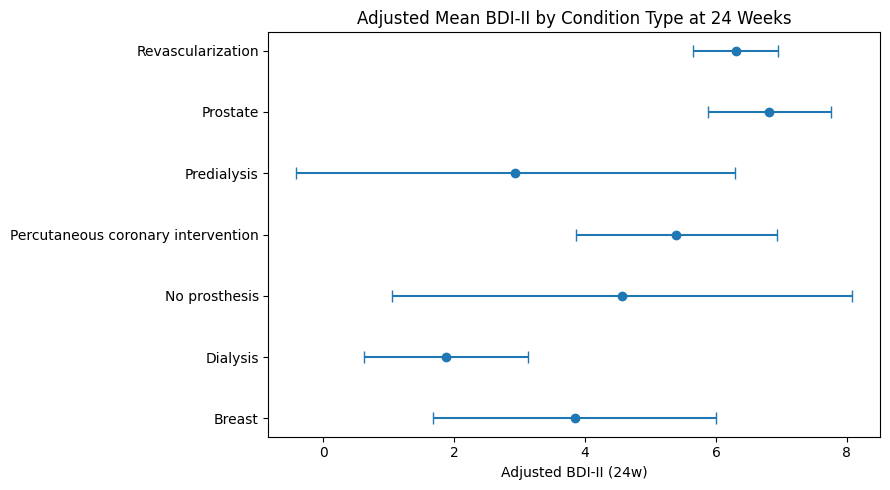

In [20]:
# Title: Adjusted Mean BDI-II by Condition Type at 24 Weeks
# Caption: Model-adjusted BDI-II by condition type at 24 weeks under the same reference values.

pred_grid24 = pd.DataFrame({
    "bdi_ii_baseline": ref_base,
    "age": ref_age,
    "completion_rate": ref_comp,
    "sex": ref_sex,
    "condition_type": cond_levels
})

pred24 = fit24.get_prediction(pred_grid24).summary_frame()
adj24  = pd.concat([pred_grid24["condition_type"].reset_index(drop=True), pred24], axis=1)

plt.figure(figsize=(9,5))
plt.errorbar(adj24["mean"], adj24["condition_type"],
             xerr=[adj24["mean"]-adj24["mean_ci_lower"], adj24["mean_ci_upper"]-adj24["mean"]],
             fmt="o", capsize=4)
plt.xlabel("Adjusted BDI-II (24w)")
plt.title("Adjusted Mean BDI-II by Condition Type at 24 Weeks")
plt.tight_layout(); plt.show()


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reference values for adjusted predictions
ref_age  = df["age"].median()
ref_base = df["bdi_ii_baseline"].median()
ref_comp = df["completion_rate"].median()
ref_sex  = df["sex"].mode()[0]

# Ensure categories are set (helps prediction grids)
df["sex"] = df["sex"].astype("category")
df["condition_type"] = df["condition_type"].astype("category")
cond_levels = df["condition_type"].cat.categories


### Growth-curve Linear Mixed Model (LMM)

In [10]:
# Long format with a participant id
df = df.copy()
df["participant_id"] = np.arange(len(df))

long = pd.wide_to_long(
    df.rename(columns={
        "bdi_ii_after_intervention_12w":"BDI_12w",
        "bdi_ii_follow_up_24w":"BDI_24w"
    }),
    stubnames=["BDI"], i="participant_id", j="time",
    sep="_", suffix="(12w|24w)"
).reset_index()

# Extract numeric time label: 12 or 24
long["time_weeks"] = long["time"].str.extract(r"(\d+)").astype(int)

# Keep needed columns and drop rows missing outcome or baseline/covars
need = ["BDI","bdi_ii_baseline","age","sex","condition_type",
        "completion_rate","hospital_center_id","participant_id","time_weeks"]
long = long[need].dropna().copy()

import statsmodels.formula.api as smf

# Mixed model: random intercept for participant; variance component for hospital
# If convergence issues occur, drop vc_formula and keep only groups=participant_id
md = smf.mixedlm(
    "BDI ~ time_weeks + bdi_ii_baseline + age + C(sex) + C(condition_type) "
    "+ completion_rate + time_weeks:completion_rate",
    data=long,
    groups=long["participant_id"]
)

mdf = md.fit(method="lbfgs", reml=False)
print(mdf.summary())



                               Mixed Linear Model Regression Results
Model:                            MixedLM               Dependent Variable:               BDI      
No. Observations:                 299                   Method:                           ML       
No. Groups:                       150                   Scale:                            18.8046  
Min. group size:                  1                     Log-Likelihood:                   -938.2342
Max. group size:                  2                     Converged:                        Yes      
Mean group size:                  2.0                                                              
---------------------------------------------------------------------------------------------------
                                                        Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------------------------------------------------
Intercept                      

c:\Users\SULTANUS SALEHIN\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


### Coefficient Plot- Growth Curve LMM

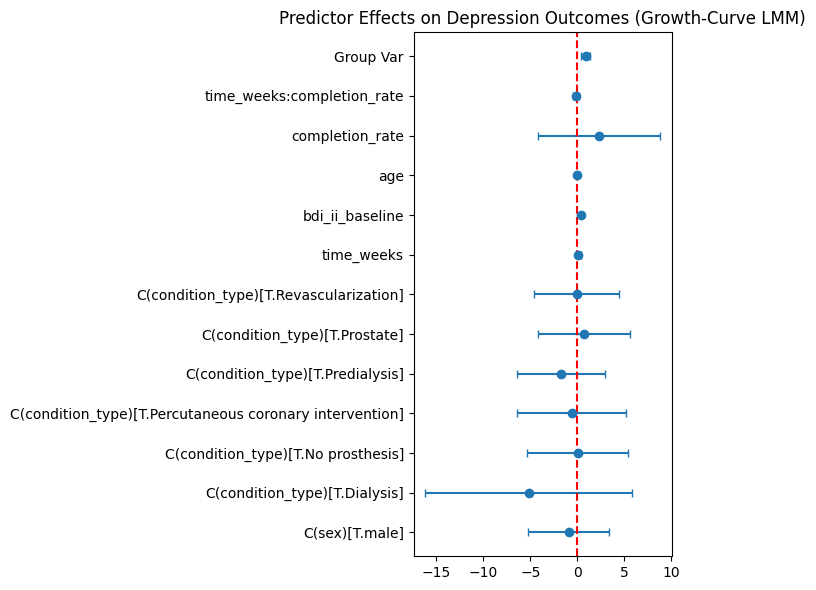

In [18]:
# Title: Predictor Effects on Depression Outcomes (Growth-Curve LMM)
# Caption: Fixed-effect coefficients with 95% CIs from the growth-curve LMM (12w & 24w jointly).

coef = mdf.params
ci   = mdf.conf_int()
plotLMM = pd.DataFrame({"term": coef.index, "coef": coef.values,
                        "lo": ci[0].values, "hi": ci[1].values})
plotLMM = plotLMM[plotLMM["term"] != "Intercept"]

plt.figure(figsize=(7,6))
y = np.arange(len(plotLMM))
plt.errorbar(plotLMM["coef"], y,
             xerr=[plotLMM["coef"]-plotLMM["lo"], plotLMM["hi"]-plotLMM["coef"]],
             fmt="o", capsize=3)
plt.yticks(y, plotLMM["term"])
plt.axvline(0, color="red", ls="--")
plt.title("Predictor Effects on Depression Outcomes (Growth-Curve LMM)")
plt.tight_layout(); plt.show()


### Predicted trajectories 12w → 24w (from LMM)

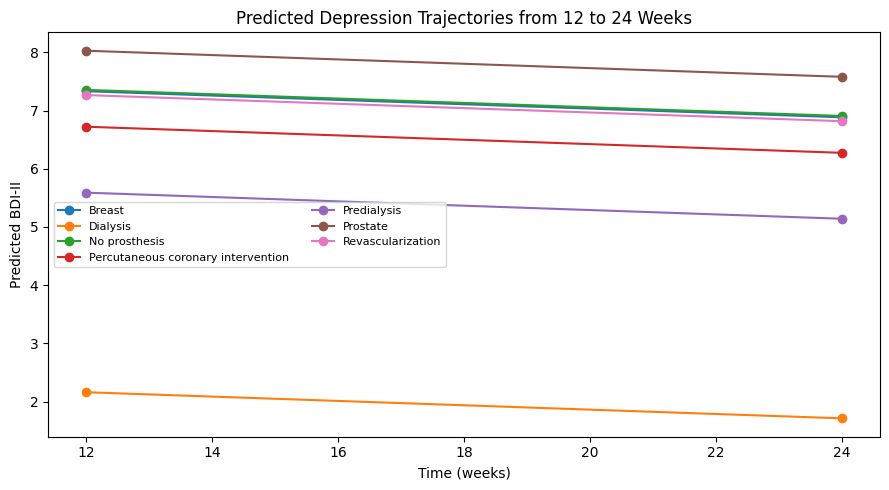

In [24]:
from patsy import dmatrix

# Build grid: two timepoints per condition
traj_grid = pd.DataFrame({
    "time_weeks": np.tile([12, 24], len(cond_levels)),
    "bdi_ii_baseline": ref_base,
    "age": ref_age,
    "sex": [ref_sex] * (2 * len(cond_levels)),
    "condition_type": np.repeat(cond_levels, 2),
    "completion_rate": ref_comp
})

# Use same RHS as LMM
fe_form = "time_weeks + bdi_ii_baseline + age + C(sex) + C(condition_type) + completion_rate + time_weeks:completion_rate"
X = dmatrix(fe_form, traj_grid, return_type="dataframe")

# keep only the columns that match your fitted model's fixed effects
X = X.reindex(columns=mdf.fe_params.index, fill_value=0)

traj_grid["pred_BDI"] = np.dot(X, mdf.fe_params)

# Plot
plt.figure(figsize=(9,5))
for cond in cond_levels:
    sub = traj_grid[traj_grid["condition_type"] == cond]
    plt.plot(sub["time_weeks"], sub["pred_BDI"], marker="o", label=str(cond))
plt.xlabel("Time (weeks)")
plt.ylabel("Predicted BDI-II")
plt.title("Predicted Depression Trajectories from 12 to 24 Weeks")
plt.legend(ncol=2, fontsize=8)
plt.tight_layout(); plt.show()


### Completion-rate effect at 12w vs 24w (from LMM)

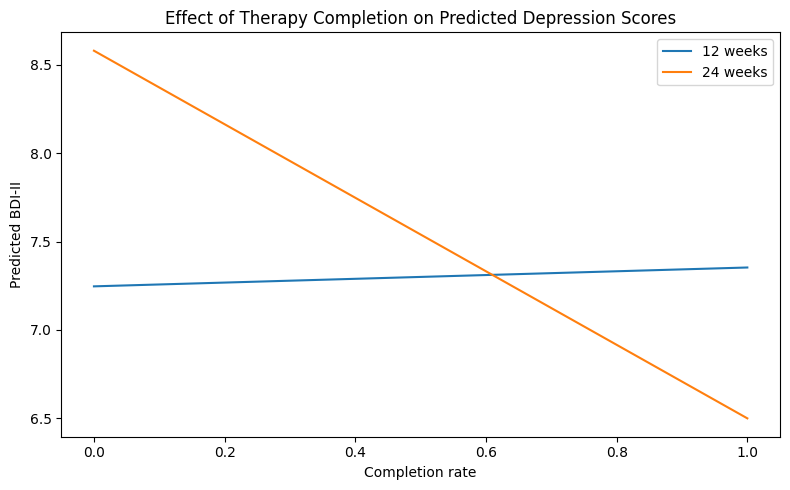

In [26]:
# Title: Effect of Therapy Completion on Predicted Depression Scores
# Caption: Predicted BDI-II at 12 and 24 weeks as a function of completion rate, adjusted for covariates.

# pick one condition type to visualize
example_cond = cond_levels[0]  # change to another group if you want

comp_grid = pd.DataFrame({
    "time_weeks": np.tile([12, 24], 50),
    "bdi_ii_baseline": ref_base,
    "age": ref_age,
    "sex": [ref_sex] * 100,
    "condition_type": [example_cond] * 100,
    "completion_rate": np.repeat(np.linspace(0, 1, 50), 2)
})

# build design matrix (no +1, intercept included automatically)
fe_form = "time_weeks + bdi_ii_baseline + age + C(sex) + C(condition_type) + completion_rate + time_weeks:completion_rate"
Xc = dmatrix(fe_form, comp_grid, return_type="dataframe")

# align columns with model params
Xc = Xc.reindex(columns=mdf.fe_params.index, fill_value=0)

# predict
comp_grid["pred_BDI"] = np.dot(Xc, mdf.fe_params)

# plot
plt.figure(figsize=(8,5))
for t in [12, 24]:
    sub = comp_grid[comp_grid["time_weeks"] == t]
    plt.plot(sub["completion_rate"], sub["pred_BDI"], label=f"{t} weeks")
plt.xlabel("Completion rate")
plt.ylabel("Predicted BDI-II")
plt.title("Effect of Therapy Completion on Predicted Depression Scores")
plt.legend()
plt.tight_layout(); plt.show()


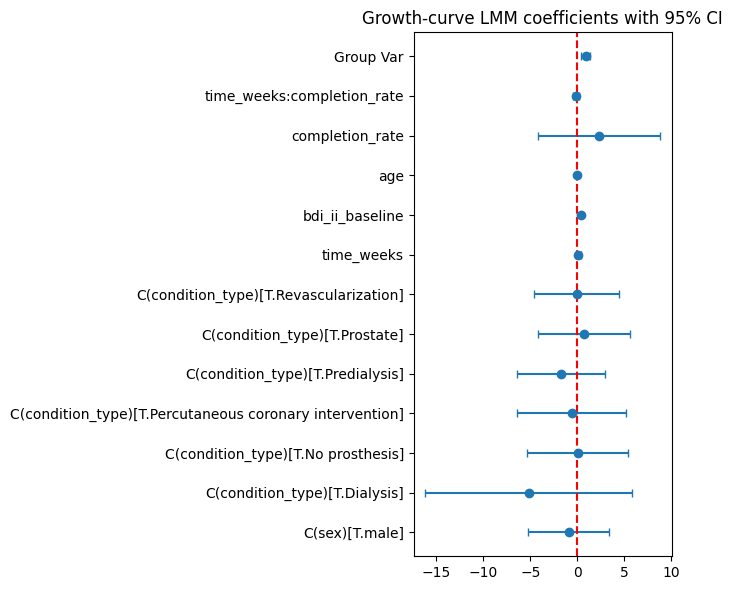

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# extract coefficients & CI from your fitted model
coef = mdf.params
ci = mdf.conf_int()
plot_df = pd.DataFrame({
    "term": coef.index,
    "coef": coef.values,
    "lo": ci[0].values,
    "hi": ci[1].values
})

# drop intercept for clarity
plot_df = plot_df[plot_df["term"] != "Intercept"]

# make a coefficient plot
plt.figure(figsize=(7, 6))
y = np.arange(len(plot_df))
plt.errorbar(plot_df["coef"], y,
             xerr=[plot_df["coef"] - plot_df["lo"], plot_df["hi"] - plot_df["coef"]],
             fmt="o", capsize=3)
plt.yticks(y, plot_df["term"])
plt.axvline(0, color="red", ls="--")
plt.title("Growth-curve LMM coefficients with 95% CI")
plt.tight_layout()
plt.show()


### Sensitivity: complete-case vs simple imputation

In [14]:
from sklearn.impute import SimpleImputer
import statsmodels.formula.api as smf

# Only impute predictors used in ANCOVA (not the outcome itself)
Xcols = ["bdi_ii_baseline","age","completion_rate","sex","condition_type","hospital_center_id"]
imp_df = df.copy()

# SimpleImputer on numerics only
num_cols = ["bdi_ii_baseline","age","completion_rate"]
imp = SimpleImputer(strategy="median")
imp_df[num_cols] = imp.fit_transform(imp_df[num_cols])

# Refit ANCOVA 12w on rows where 12w outcome exists (predictors now imputed)
cc12_imp = imp_df.dropna(subset=["BDI_12w"])[["BDI_12w"] + Xcols]

fit12_imp = smf.ols(
    "BDI_12w ~ bdi_ii_baseline + age + C(sex) + C(condition_type) + completion_rate",
    data=cc12_imp
).fit(cov_type="cluster", cov_kwds={"groups": cc12_imp["hospital_center_id"]})

print(fit12_imp.summary())


                            OLS Regression Results                            
Dep. Variable:                BDI_12w   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     3.270
Date:                Thu, 25 Sep 2025   Prob (F-statistic):              0.234
Time:                        14:24:49   Log-Likelihood:                -531.37
No. Observations:                 167   AIC:                             1085.
Df Residuals:                     156   BIC:                             1119.
Df Model:                          10                                         
Covariance Type:              cluster                                         
                                                              coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------

c:\Users\SULTANUS SALEHIN\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 10, but rank is 2
  warnings.warn('covariance of constraints does not have full '
